# Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection

## Text Classification Architecture

https://www.kaggle.com/c/fake-news/data

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

- smam classification, sentiment classification, toxic comment, emotion classification etc.


## Coding

In [ ]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

In [2]:
# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

In [5]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [6]:
df.shape

df['label'].value_counts()

,count
label,
0,10361
1,7920


## Dataset Analysis

In [7]:
import matplotlib.pyplot as plt

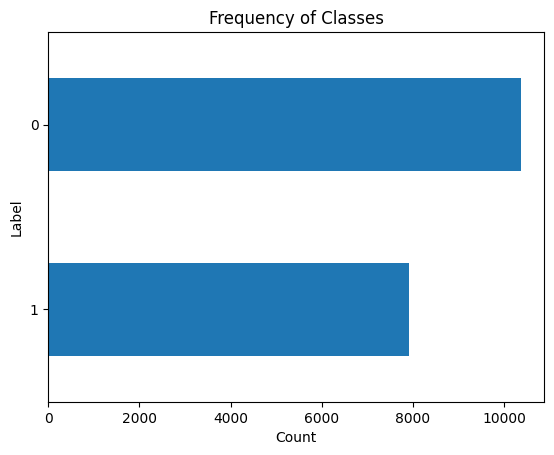

In [12]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

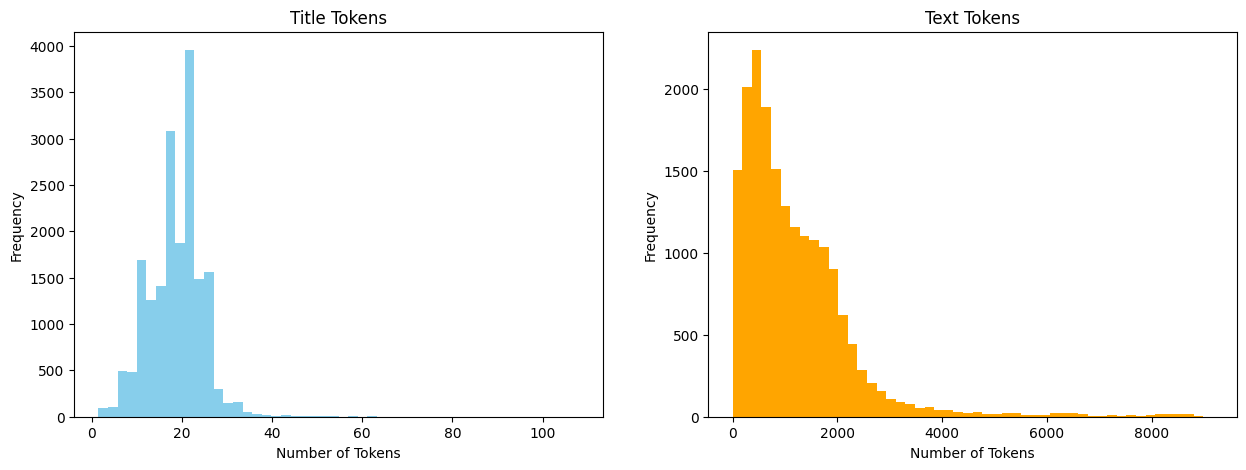

In [15]:
# 1.5 tokens per word on average
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(df['text_tokens'], bins=100, color = 'orange')
ax.axvline(x=512, color='red', linestyle='--', label='Model Limit (512 tokens)')
ax.set_title("Distribution of Text Tokens (Estimated)")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Frequency")
ax.legend()

plt.show()

long_texts = (df['text_tokens'] > 512).sum()
print(f"Number of documents exceeding 512 tokens: {long_texts} ({long_texts/len(df)*100:.2f}%)")

## Data Loader and Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [17]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Data Tokenization

In [ ]:
from transformers import AutoTokenizer

text = "Machine learning is awesome!! Thanks KGP Talkie."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)


In [19]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [20]:
def tokenize(batch):
    # Set return_overflowing_tokens=True to create chunks
    # Use max_length=512 and stride for overlap
    tokenized_inputs = distilbert_tokenizer(
        batch['text'], 
        padding=True, 
        truncation=True, 
        max_length=512,
        return_overflowing_tokens=True,
        stride=128
    )
    
    # map overflowing tokens to their corresponding original samples
    sample_mapping = tokenized_inputs.pop("overflow_to_sample_mapping")
    
    # We need the original ids to aggregate later
    tokenized_inputs['original_id'] = [batch['id'][i] for i in sample_mapping]
    
    # duplicate labels for each chunk
    labels = batch['label']
    tokenized_inputs['labels'] = [labels[i] for i in sample_mapping]
    
    return tokenized_inputs

print('Tokenizing a long document sample...')
sample_batch = dataset['train'][:1]
output = tokenize(sample_batch)
print(f'Original text length: {len(sample_batch["text"][0].split())} words')
print(f'Number of chunks generated: {len(output["input_ids"])}')


{'input_ids': [[101, 1521, 6521, 24642, 1521, 7984, 4152, 2178, 6271, 2007, 2317, 2160, 19076, 1997, 7023, 1011, 7987, 20175, 8237, 2102, 102], [101, 2047, 8554, 3065, 7672, 2007, 1021, 2391, 2599, 1999, 4108, 2569, 7740, 2602, 1011, 7987, 20175, 8237, 2102, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [ ]:
encoded_dataset = dataset.map(tokenize, batched=True, remove_columns=dataset['train'].column_names)
print(f'Encoded dataset sizes: {encoded_dataset}')


## Model Building

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)




In [23]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.3",
  "vocab_size": 30522
}

## Model Fine-Tuning

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

#### Evaluator

https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [ ]:
!pip install evaluate

In [ ]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [28]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 3,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = 'epoch'
)



In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

In [30]:
trainer.train()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
500,0.253200
1000,0.180900
1500,0.172800
2000,0.111000
2500,0.096400
3000,0.088900
3500,0.054200
4000,0.044200
4500,0.031400


TrainOutput(global_step=4800, training_loss=0.1099693375825882, metrics={'train_runtime': 590.7619, 'train_samples_per_second': 64.98, 'train_steps_per_second': 8.125, 'total_flos': 953467218676224.0, 'train_loss': 0.1099693375825882, 'epoch': 3.0})

## Model Evaluation

In [32]:
preds_output = trainer.predict(encoded_dataset['test'])


In [33]:
preds_output.metrics

{'test_loss': 0.20298099517822266,
 'test_accuracy': 0.9589715536105032,
 'test_runtime': 9.4655,
 'test_samples_per_second': 386.243,
 'test_steps_per_second': 48.28}

In [34]:
import pandas as pd
import numpy as np

predictions_df = pd.DataFrame({
    'original_id': encoded_dataset['test']['original_id'],
    'logits_0': preds_output.predictions[:, 0],
    'logits_1': preds_output.predictions[:, 1],
    'label': preds_output.label_ids
})

# Mean pooling of logits per original document
aggregated_predictions = predictions_df.groupby('original_id').mean()
y_pred = np.argmax(aggregated_predictions[['logits_0', 'logits_1']].values, axis=1)
y_true = aggregated_predictions['label'].astype(int).values

print(f'Aggregated predictions for {len(y_true)} unique documents.')


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      2072
        Fake       0.95      0.95      0.95      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## Benchmarking

In [36]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics


import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}

In [38]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.21810635924339294,
   'test_accuracy': 0.9606126914660832,
   'test_f1': 0.9606007794974527,
   'test_runtime': 19.0098,
   'test_samples_per_second': 192.322,
   'test_steps_per_second': 24.04},
  'time taken': 974.969975233078},
 'distilbert': {'distilbert': {'test_loss': 0.20091082155704498,
   'test_accuracy': 0.962253829321663,
   'test_f1': 0.9622648635787883,
   'test_runtime': 9.4816,
   'test_samples_per_second': 385.588,
   'test_steps_per_second': 48.199},
  'time taken': 560.2191379070282},
 'mobilebert': {'mobilebert': {'test_loss': 0.23082439601421356,
   'test_accuracy': 0.9567833698030634,
   'test_f1': 0.9567463728658184,
   'test_runtime': 21.6784,
   'test_samples_per_second': 168.647,
   'test_steps_per_second': 21.081},
  'time taken': 948.0319578647614},
 'tinybert': {'tinybert': {'test_loss': 0.1974892020225525,
   'test_accuracy': 0.9611597374179431,
   'test_f1': 0.9611479908933214,
   'test_runtime': 2.9917,
   'test

# Model Load and Save

In [39]:
trainer.save_model("fake_news")

In [40]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'fake_news')


Device set to use cuda:0


In [41]:
classifier("some text data")

[{'label': 'Fake', 'score': 0.9997765421867371}]